In [2]:
# can plot 2d histograms of arbitrary variables stored in the tree

In [3]:
import sys
sys.path.insert(0, '/home/llr/cms/wind/cmssw/CMSSW_9_4_2/src/ZZAnalysis/AnalysisStep/test/Python/')

In [4]:
from trainlib.FileCollection import FileCollection
import trainlib.cuts as cuts
from trainlib.utils import read_data
from trainlib.config import Config
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import re
import pandas as pd
import numpy as np

Welcome to JupyROOT 6.10/09


In [5]:
def extract_column(df, colstring):
    if '[' in colstring and ']' in colstring:
        col, sorted_col_order, _ = re.split('[\[\]]', colstring)
        sorted_col, order = re.split('\|', sorted_col_order)
        cf = extract_order_filtered(df, sorted_col, [col], int(order))
    else:
        cf = df[[colstring]]
    return cf

In [6]:
def extract_order_filtered(df, sorted_column, columns, order):
    extracted_raw = extract_order(df, sorted_column, columns, order)

    if any("Jet" in col for col in extracted_raw.columns):
        # apply the jet-pt cut
        mask_column = extract_order(df, "JetPt", ["JetPt"], order)
        mask = mask_column < 30.0
        extracted_raw[mask.as_matrix()] = 0.0

    return extracted_raw

In [7]:
def extract_order(df, sorted_column, columns, order):
    def get_index(row, order, sorted_column):
        sorted_column = row[sorted_column]
        if order >= len(sorted_column):
            return -1
        else:
            return np.flipud(np.argsort(sorted_column))[order]

    index_column = pd.DataFrame(df.transform(lambda row: get_index(row, order, sorted_column), axis = 1, raw = True))
    index_column.columns = ["index"]
    df_temp = pd.concat([index_column, df], axis = 1)

    def get_element(row, column_name):
        if row["index"] == -1:
            return 0
        else:
            return row[column_name][row["index"]]

    extracted_cols = pd.DataFrame()
    for column in columns:
        extracted_col = pd.DataFrame(df_temp.transform(lambda row: get_element(row, column), axis = 1, raw = True))
        extracted_col.columns = [column + "_" + str(order)]
        extracted_cols = pd.concat([extracted_cols, extracted_col], axis = 1)

    return extracted_cols

In [8]:
def plot_2d_histogram(df, x_var, y_var, x_range, y_range, x_label, y_label, log_scale = True):
    x_data = extract_column(df, x_var).as_matrix().flatten()
    y_data = extract_column(df, y_var).as_matrix().flatten()
    
    print str(np.corrcoef(x_data, y_data))
    
    x_edges = np.linspace(x_range[0], x_range[1], x_range[2])
    y_edges = np.linspace(y_range[0], y_range[1], y_range[2])
    
    weights = np.full(len(x_data), 1.0 / len(x_data))
    
    H, x_edges, y_edges = np.histogram2d(x_data, y_data, bins = (x_edges, y_edges), weights = weights)
    
    return plot_2d_raw(H.transpose(), x_edges, y_edges, x_label, y_label, log_scale = log_scale), H

In [9]:
def plot_2d_histogram_relative(df, x_var, y_var, x_range, y_range, x_label, y_label, log_scale = True):
    x_data = extract_column(df, x_var).as_matrix().flatten()
    y_data = extract_column(df, y_var).as_matrix().flatten()
    
    y_data = y_data / x_data
    
    x_edges = np.linspace(x_range[0], x_range[1], x_range[2])
    y_edges = np.linspace(y_range[0], y_range[1], y_range[2])
    
    weights = np.full(len(x_data), 1.0 / len(x_data))
    
    H, x_edges, y_edges = np.histogram2d(x_data, y_data, bins = (x_edges, y_edges), weights = weights)
    
    return plot_2d_raw(H.transpose(), x_edges, y_edges, x_label, y_label, log_scale = log_scale), H

In [68]:
def plot_1d_histogram(dfs, x_vars, data_labels, x_range, x_label, y_label = "", log_scale = True):
    
    fig = plt.figure(figsize = (8,5))
    ax = fig.add_subplot(111)
    
    for df, x_var, data_label in zip(dfs, x_vars, data_labels):
        x_data = extract_column(df, x_var).as_matrix().flatten()

        x_edges = np.linspace(x_range[0], x_range[1], x_range[2])
        bin_width = (x_range[1] - x_range[0]) / (x_range[2] - 1)
        
        MC_weights = extract_column(df, "training_weight").as_matrix().flatten()
        total_MC_weights = sum(MC_weights)
        
        weights = np.full(len(x_data), 1.0 / (bin_width * total_MC_weights))
        weights = np.multiply(weights, MC_weights)
                                
        H, x_edges = np.histogram(x_data, bins = x_edges, weights = weights)

        cax = ax.hist(x_data, bins = x_edges, log = log_scale, weights = weights, histtype = 'step', label = data_label)
        ax.set_xlabel(x_label, fontsize = 15)
        ax.set_ylabel(y_label, fontsize = 12)
        #ax.set_xlim([x_range[0], x_range[1] - 0.01])
        
    ax.legend(loc = 'lower left')
        
    return fig, H

In [11]:
def plot_2d_raw(H, x_edges, y_edges, x_label, y_label, log_scale = True):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
        
    if log_scale:
        cax = ax.imshow(H, interpolation = "nearest", cmap = "hot", origin = "low", aspect = 'auto',
                        extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                       norm = LogNorm(vmin = 0.0001, vmax = 1))
    else:
        cax = ax.imshow(H, interpolation = "nearest", cmap = "hot", origin = "low", aspect = 'auto',
                extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
    
    ax.set_xlabel(x_label, fontsize = 15)
    ax.set_ylabel(y_label, fontsize = 15)
        
    return fig

In [12]:
j2cut = lambda row: row["nCleanedJetsPt30"] >= 2

In [13]:
j0cut = lambda row: row["nCleanedJetsPt30"] == 0

In [14]:
j1cut = lambda row: row["nCleanedJetsPt30"] == 1

In [15]:
whhadr_2jcut = lambda row: cuts.WHhadr_cut(row) and j2cut(row)

In [16]:
zhhadr_2jcut = lambda row: cuts.ZHhadr_cut(row) and j2cut(row)

In [17]:
zhlept_2jcut = lambda row: cuts.ZHlept_cut(row) and j2cut(row)

In [18]:
zhlept_mass_cut = lambda row: cuts.ZHlept_cut(row) and cuts.mZZ_cut(row)
whlept_mass_cut = lambda row: cuts.WHlept_cut(row) and cuts.mZZ_cut(row)

In [19]:
local_mass_cut = lambda row: row["ZZMass"] < 140 and row["ZZMass"] > 105

In [20]:
input_stream_VBF_0j = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/VBFH125/ZZ4lAnalysis.root" : j0cut}
input_stream_ggH_0j = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/ggH125/ZZ4lAnalysis.root" : j0cut}
input_stream_VBF_1j = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/VBFH125/ZZ4lAnalysis.root" : j1cut}
input_stream_ggH_1j = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/ggH125/ZZ4lAnalysis.root" : j1cut}
input_stream_VBF_2j = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/VBFH125/ZZ4lAnalysis.root" : j2cut}
input_stream_ggH_2j = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/ggH125/ZZ4lAnalysis.root" : j2cut}

input_stream_VBF = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/VBFH125/ZZ4lAnalysis.root" : cuts.no_cut}
input_stream_ggH = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/ggH125/ZZ4lAnalysis.root" : cuts.no_cut}

input_stream_ttHl = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/ttH125/ZZ4lAnalysis.root": cuts.ttHlept_cut}
input_stream_ttHh = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/ttH125/ZZ4lAnalysis.root": cuts.ttHhadr_cut}

input_stream_bbH = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/bbH125/ZZ4lAnalysis.root": cuts.no_cut}
input_stream_bbH_0j = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/bbH125/ZZ4lAnalysis.root": j0cut}
input_stream_bbH_1j = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/bbH125/ZZ4lAnalysis.root": j1cut}
input_stream_bbH_2j = {"/data_CMS/cms/wind/CJLST_NTuples_prepared/bbH125/ZZ4lAnalysis.root": j2cut}

In [21]:
fcoll = FileCollection(input_stream_ttHl, 0.0, 1.0)
plot_data_ttHl = read_data(fcoll, 0, 39000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/ttH125/ZZ4lAnalysis.root
collection set up: 1 files, 39490 entries in total, 39490 of which will be used


In [22]:
fcoll = FileCollection(input_stream_ttHh, 0.0, 1.0)
plot_data_ttHh = read_data(fcoll, 0, 39000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/ttH125/ZZ4lAnalysis.root
collection set up: 1 files, 39490 entries in total, 39490 of which will be used


In [23]:
fcoll = FileCollection(input_stream_VBF_0j, 0.0, 1.0)
plot_data_VBF_0j = read_data(fcoll, 0, 15000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/VBFH125/ZZ4lAnalysis.root
collection set up: 1 files, 62320 entries in total, 62320 of which will be used


In [24]:
fcoll = FileCollection(input_stream_ggH_0j, 0.0, 1.0)
plot_data_ggH_0j = read_data(fcoll, 0, 15000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/ggH125/ZZ4lAnalysis.root
collection set up: 1 files, 110483 entries in total, 110483 of which will be used


In [25]:
fcoll = FileCollection(input_stream_VBF_1j, 0.0, 1.0)
plot_data_VBF_1j = read_data(fcoll, 0, 62000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/VBFH125/ZZ4lAnalysis.root
collection set up: 1 files, 62320 entries in total, 62320 of which will be used


In [26]:
fcoll = FileCollection(input_stream_ggH_1j, 0.0, 1.0)
plot_data_ggH_1j = read_data(fcoll, 0, 110000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/ggH125/ZZ4lAnalysis.root
collection set up: 1 files, 110483 entries in total, 110483 of which will be used


In [27]:
fcoll = FileCollection(input_stream_VBF_2j, 0.0, 1.0)
plot_data_VBF_2j = read_data(fcoll, 0, 62000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/VBFH125/ZZ4lAnalysis.root
collection set up: 1 files, 62320 entries in total, 62320 of which will be used


In [28]:
fcoll = FileCollection(input_stream_ggH_2j, 0.0, 1.0)
plot_data_ggH_2j = read_data(fcoll, 0, 110000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/ggH125/ZZ4lAnalysis.root
collection set up: 1 files, 110483 entries in total, 110483 of which will be used


In [29]:
fcoll = FileCollection(input_stream_VBF, 0.0, 1.0)
plot_data_VBF = read_data(fcoll, 0, 62000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/VBFH125/ZZ4lAnalysis.root
collection set up: 1 files, 62320 entries in total, 62320 of which will be used


In [30]:
fcoll = FileCollection(input_stream_ggH, 0.0, 1.0)
plot_data_ggH = read_data(fcoll, 0, 110000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/ggH125/ZZ4lAnalysis.root
collection set up: 1 files, 110483 entries in total, 110483 of which will be used


In [77]:
fcoll = FileCollection(input_stream_bbH, 0.0, 1.0)
plot_data_bbH = read_data(fcoll, 0, 62000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/bbH125/ZZ4lAnalysis.root
collection set up: 1 files, 62503 entries in total, 62503 of which will be used


In [99]:
fcoll = FileCollection(input_stream_bbH_2j, 0.0, 1.0)
plot_data_bbH_2j = read_data(fcoll, 0, 62000, branches = Config.branches)

skimming /data_CMS/cms/wind/CJLST_NTuples_prepared/bbH125/ZZ4lAnalysis.root
collection set up: 1 files, 62503 entries in total, 62503 of which will be used


/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


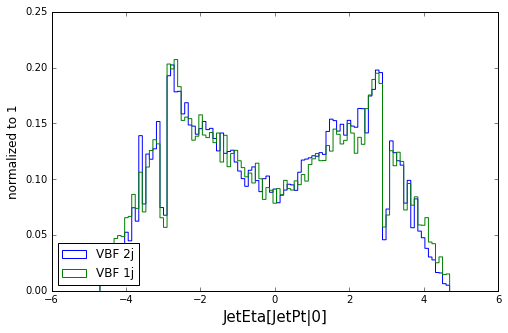

In [71]:
fig, H_ZX = plot_1d_histogram([plot_data_VBF_2j, plot_data_VBF_1j], 
                              ["JetEta[JetPt|0]", "JetEta[JetPt|0]"], 
                              ["VBF 2j", "VBF 1j"], (-4.7, 4.7, 100.), 'JetEta[JetPt|0]', "normalized to 1", log_scale = False)
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


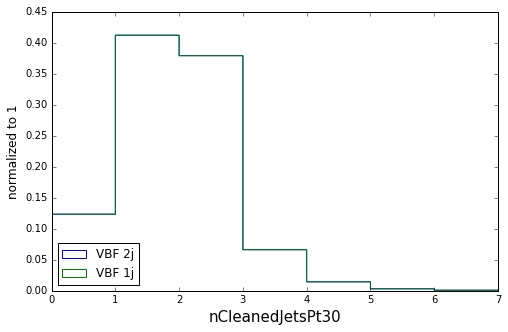

In [70]:
fig, H_ZX = plot_1d_histogram([plot_data_VBF, plot_data_VBF], 
                              ["nCleanedJetsPt30", "nCleanedJetsPt30"], 
                              ["VBF 2j", "VBF 1j"], (0, 7, 8.), 'nCleanedJetsPt30', "normalized to 1", log_scale = False)
plt.show()

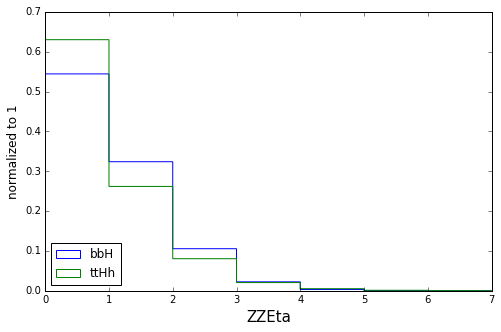

In [87]:
fig, H_ZX = plot_1d_histogram([plot_data_bbH, plot_data_ggH], 
                              ["nCleanedJetsPt30", "nCleanedJetsPt30"], 
                              ["bbH", "ttHh"], (0, 7, 8), 'ZZEta', "normalized to 1", log_scale = False)
#plt.savefig("ZX_ZHl_Zhl_ggH.pdf")
plt.show()

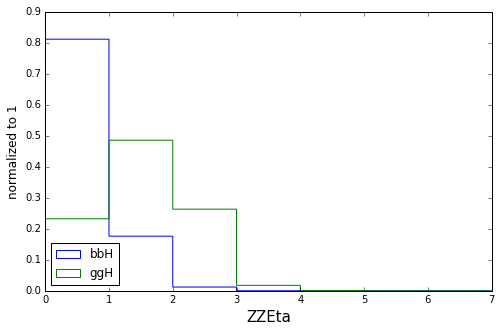

In [93]:
fig, H_ZX = plot_1d_histogram([plot_data_bbH, plot_data_ttHl], 
                              ["nCleanedJetsPt30BTagged_bTagSF", "nCleanedJetsPt30BTagged_bTagSF"], 
                              ["bbH", "ggH"], (0, 7, 8), 'ZZEta', "normalized to 1", log_scale = False)
#plt.savefig("ZX_ZHl_Zhl_ggH.pdf")
plt.show()

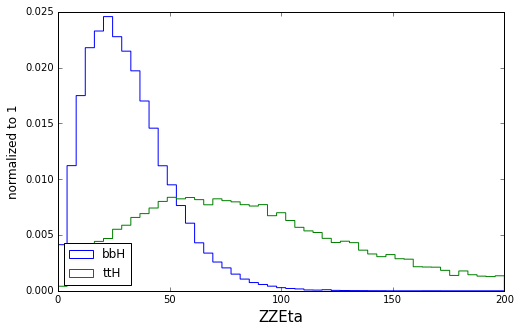

In [98]:
fig, H_ZX = plot_1d_histogram([plot_data_bbH, plot_data_ttHl], 
                              ["PFMET", "PFMET"], 
                              ["bbH", "ttH"], (0, 200, 50), 'ZZEta', "normalized to 1", log_scale = False)
#plt.savefig("ZX_ZHl_Zhl_ggH.pdf")
plt.show()

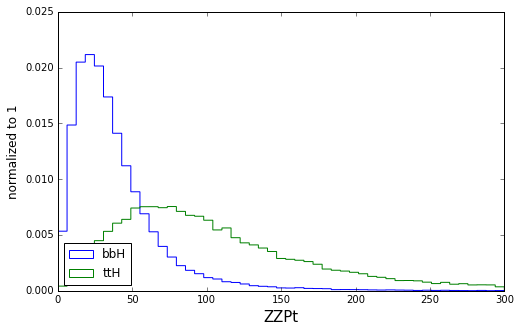

In [123]:
fig, H_ZX = plot_1d_histogram([plot_data_bbH, plot_data_ttHl], 
                              ["ZZPt", "ZZPt"], 
                              ["bbH", "ttH"], (0, 300, 50), 'ZZPt', "normalized to 1", log_scale = False)
#plt.savefig("ZX_ZHl_Zhl_ggH.pdf")
plt.show()

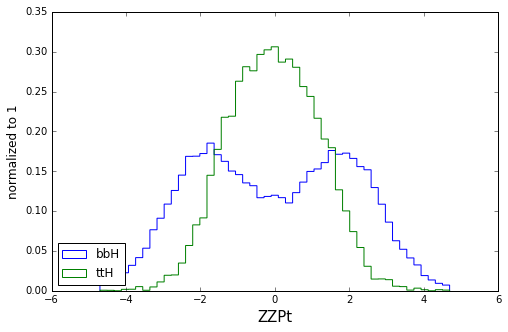

In [124]:
fig, H_ZX = plot_1d_histogram([plot_data_bbH, plot_data_ttHh], 
                              ["ZZEta", "ZZEta"], 
                              ["bbH", "ttH"], (-4.7, 4.7, 50), 'ZZPt', "normalized to 1", log_scale = False)
#plt.savefig("ZX_ZHl_Zhl_ggH.pdf")
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-fmblme/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


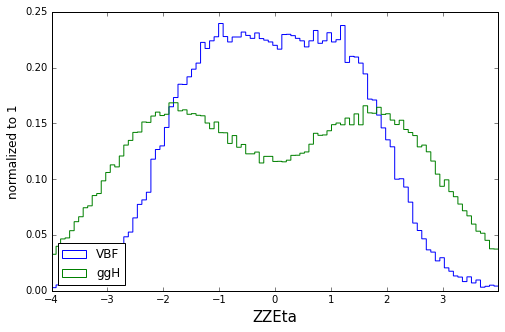

In [24]:
fig, H_ZX = plot_1d_histogram([plot_data_VBF, plot_data_ggH], 
                              ["ZZEta", "ZZEta"], 
                              ["VBF", "ggH"], (-4, 4, 100.), 'ZZEta', "normalized to 1", log_scale = False)
#plt.savefig("ZX_ZHl_Zhl_ggH.pdf")
plt.show()

In [73]:
fig, H_VBF = plot_2d_histogram(plot_data_VBF_2j, "JetPt[JetPt|0]", "JetEta[JetPt|0]", (30, 500, 10), (-4.7, 4.7, 10), "Pt", "Eta")

[[ 1.          0.00750284]
 [ 0.00750284  1.        ]]


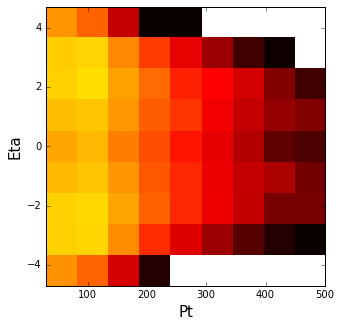

In [74]:
plt.show()